# Predictive Modelling: SVM

# Imports

In [131]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

#
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix

from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from src.models.hyperparameter_optimization import search_space

import time

# scikit-learn
from sklearn.svm import SVC


import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Defining functions

In [9]:
def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        prices,
        model,
        silent = False,
    ):
    start = time.time()
    cnt = 1
    df_score = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df_score.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    df_returns = df_score.copy()
    # Loop over forecast horizons
    for i, fh in enumerate(forecast_horizon):
        # Loop over input / lookback windows
        for j, iw in enumerate(input_window_size):
            total = len(forecast_horizon)*len(input_window_size)
            model.fit(X_train[symbol][[f'{x}_{iw}' for x in ti_list]], y_train[symbol][f'signal_{fh}'])
            y_pred = model.predict(X_test[symbol][[f'{x}_{iw}' for x in ti_list]])
            # Calculate accuracy score ()
            a_score = accuracy_score(y_test[symbol][f'signal_{fh}'], y_pred)
            # Calculate returns generated by stratedy
            returns = calc_returns(y_pred, prices[symbol])
            cum_returns = returns['Cum_Returns_Strat'][-1]
            df_score.iloc[i, j] = a_score
            df_returns.iloc[i, j] = cum_returns
            if silent == False:
                clear_output(wait=True)
                display(f'Leg [{cnt} / {total}]; Test Score {a_score}; Test Returns {cum_returns}')
            cnt += 1
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df_score, df_returns

In [10]:
def avg_model2(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=None,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=xgb_optm,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s')
        cnt += 1
    avg_results = pd.DataFrame(
        np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
        columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
    return avg_results, results_dict, returns_dict

In [11]:
def avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=model,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        avg_results = pd.DataFrame(
            np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
            columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s\n', avg_results)
        cnt += 1

    return avg_results, results_dict, returns_dict

In [12]:
from sklearn.model_selection import BaseCrossValidator
class BlockingTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [13]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

## Loading the data

In [14]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [15]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

## Imputing missing values

In [16]:
X.shape

(1954, 4800)

In [17]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [18]:
prices.shape

(1954, 250)

In [19]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [20]:
y_3c.shape

(1954, 450)

In [21]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [22]:
y2.shape

(1954, 450)

In [23]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [19]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [20]:
scaled = scale.fit_transform(X)

In [21]:
scaled.shape

(1954, 4800)

In [22]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Train-Test Split

In [26]:
# Use 70/30 train/test splits
test_p = .3

In [25]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [27]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [40]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [46]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [48]:
symbol = 'T'
n = 15

## Single lookback/lookahead combination

In [56]:
svc = SVC(kernel='rbf')
#result_matrix = svc.fit('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, svc)

svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
y_pred_svc = svc.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_svc))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_svc))
#plot_feature_importances(svc.coef_,
#                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
#                         model='SVC1', top_count=100)

              precision    recall  f1-score   support

           0       0.54      0.29      0.38       268
           1       0.57      0.80      0.66       319

    accuracy                           0.56       587
   macro avg       0.56      0.54      0.52       587
weighted avg       0.56      0.56      0.53       587

[[ 77 191]
 [ 65 254]]


## All combinations

'Leg [72 / 72]; Test Score 0.575809199318569; Test Returns 0.12480497360229492'

Elapsed time 6.0s.


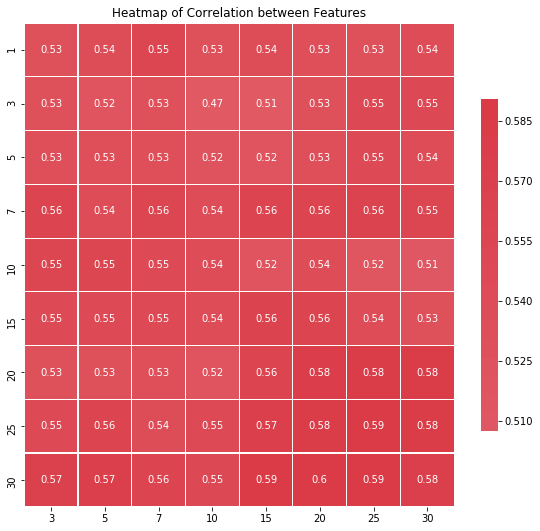

In [54]:
svm2 = SVC(kernel='rbf')
score_svm, returns_svm = run_combinations(
    symbol,
    forecast_horizon,
    input_window_size,
    X_train,
    X_test,
    y_train,
    y_test,
    prices_test,
    svm2
)

plot_corr_matrix(score_svm, mask_upper=False, show_annot=True, figsize=(8, 8))

## Averaging across all 50 randomly selected stocks

In [172]:
avg, _, _ = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    svm2,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


## Hyperparamter Optimization: GridSearch

In [132]:
tscv = TimeSeriesSplit(n_splits=5)

In [128]:
symbol = 'T'
n=30
btscv = BlockingTimeSeriesSplit(n_splits=5)


In [ ]:
start = time.time()

# kernel = 'rbf', 'linear, 'poly'
# gamma only for non-linear kernels (poly, rbf)
# C penalty for error term
# degrees = [0, 1, 2, 3, 4, 5, 6] only for kernel = poly
gammas = [10, 1, 0.1, 0.01, 0.001, 1E-4, 1E-5, 1E-6]
cs = [1, 10, 100, 1000, 1E4, 1E5, 1E6]
param_search = [
    {'kernel': ['rbf'], 'gamma': gammas, 'C': cs},
    #{'kernel': ['poly'], 'gamma': gammas, 'C': cs, 'degree' : [0, 1, 2, 3, 4, 5, 6]},
    #{'kernel': ['linear'], 'C': cs}
]

svm_gs = SVC()
gsearch_svc = GridSearchCV(
    estimator=svm_gs,                   
    cv=tscv,      
    param_grid=param_search,                      
    scoring = 'accuracy',
    n_jobs=-1
)
gsearch_svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])
print(f'Elapsed time: {round(time.time()-start, 0)}s')

In [166]:
from sklearn.model_selection import cross_val_score

In [91]:
estimator = gsearch_svc.best_estimator_
cvs = cross_val_score(
    estimator, 
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    cv=tscv.split(y_train[symbol][f'signal_{n}'])
)
results = pd.DataFrame(gsearch_svc.cv_results_)
print('##### Results #####')
print('Score best parameters: ', gsearch_svc.best_score_)
print('Best parameters: ', gsearch_svc.best_params_)
print('Cross-validation Score: ', cvs.mean())
print('Test Score: ', estimator.score(X_test[symbol][[f'{x}_{n}' for x in ti_list]], y_test[symbol][f'signal_{n}']))
print('Parameter combinations evaluated: ', results.shape[0])

NameError: name 'gsearch_svc' is not defined

In [163]:
gsearch_svc.best_score_

0.5876651982378854

## Hyperparamter Optimization: Bayesian Optimization

In [78]:
from hyperopt import space_eval

In [150]:
def BayesianSearch(param_space, model, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def scale_normalize(params, data):
        s = params.get('scale')
        n = params.get('normalize')
        if s:
            data = StandardScaler().fit_transform(data)
        if n:
            data = MinMaxScaler().fit_transform(data)
        return data
    
    def objective_function(params):
        #model2 = params.get('model')
        X_ = X_train
        #if model != RandomForestClassifier:
        X_ = scale_normalize(params, X_train[:])
        try:
            del params['model']
            del params['scale']
            del params['normalize']
        except:
            pass
        clf = model(n_jobs=-1, **params)
        score = cross_val_score(
            clf, 
            X_, 
            y_train,
            #cv=5,
            #cv=tscv.split(X_train),
            cv=btscv.split(X_train)
        ).mean()
        #print(params)
        #print('Current accuracy:', score)
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(
        fn=objective_function, 
        space=param_space, 
        algo=tpe.suggest, 
        max_evals=num_eval, 
        trials=trials,
        #rstate=np.random.RandomState(1)
    )
    loss = [x['result']['loss'] for x in trials.trials]
    results = space_eval(param_space, best_param)
    try:
        del results['model']
        del results['scale']
        del results['normalize']
    except:
        pass
    #best_param.update({'criterion': param_space.get('criterion')[best_param.get('criterion')]})
    print('##### Results #####')
    print('Score best parameters: ', min(loss))
    print('Best parameters: ', results)
    clf_best = model(
        **results
        #gamma=best_param_values[1],
        #C=best_param_values[2],
        #kernel=kernel[best_param_values[2]]
        #score='accuracy'
    )
    #print(clf_best)
    clf_best.fit(X_train, y_train)
    
    print('Test Score: ', clf_best.score(X_test, y_test))
    print('Parameter combinations evaluated: ', num_eval)
    print('Time elapsed: ', time.time() - start)

In [138]:
n=15
symbol='T'

model = SVC
bsearch_svm = BayesianSearch(
    search_space(SVC),
    #param_hyperopt,
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=500
)

100%|██████████| 500/500 [00:18<00:00, 27.52it/s, best loss: -0.6509090909090909]
##### Results #####
Score best parameters:  -0.6509090909090909
Best parameters:  {'C': 36.413446863157844, 'gamma': 65.83460655051485}
Test Score:  0.5434412265758092
Parameter combinations evaluated:  500
Time elapsed:  18.254638671875


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_svm = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=20
)

 30%|███       | 6/20 [00:17<00:45,  3.28s/it, best loss: -0.4960352422907489] 

## Running on all 50 stocks

In [62]:
best_params = {'C': 668.8245659886662, 'gamma': 5.531582161052728e-08}
model_2a = SVC(**best_params)
avg, _, _ = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=model_2a,
    silent = False
)

'Leg [50/50]; Elapsed Time 382.0s\n'

,3,5,7,10,15,20,25,30
1,0.520647,0.520579,0.521363,0.522317,0.520409,0.521465,0.523475,0.525554
3,0.538433,0.535775,0.53506,0.534651,0.535264,0.534719,0.532334,0.533424
5,0.540681,0.537411,0.536627,0.538603,0.540375,0.541942,0.54075,0.540954
7,0.547155,0.546235,0.547871,0.548893,0.548825,0.550664,0.548416,0.54879
10,0.550221,0.552266,0.552436,0.552436,0.552402,0.549847,0.551278,0.551244
15,0.547496,0.548484,0.546303,0.546678,0.544634,0.543032,0.543169,0.541295
20,0.5477,0.548995,0.547019,0.544089,0.542794,0.542249,0.539761,0.542964
25,0.545928,0.547939,0.547291,0.542283,0.539625,0.539523,0.540136,0.54017
30,0.555707,0.554446,0.552402,0.5477,0.550528,0.549779,0.549915,0.55155


In [159]:
avg

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535
